In [2]:
from rfgap import RFGAP
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from dataset import dataprep
from phate import PHATE

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

In [3]:
# Read in and prepare the data

data   = pd.read_csv('../datasets/waveform.csv', sep = ',')
x, y   = dataprep(data, scale = None)
n, d   = x.shape
n_classes = len(y.unique())

x_train, x_test, y_train, y_test, inds_train, inds_test = train_test_split(x, y, np.arange(n), test_size=0.1, random_state = 42)

In [4]:
# Random forest on all data for PHATE embedding visualization
rfphate = RFGAP(oob_score = True, non_zero_diagonal = True, random_state = 42)
rfphate.fit(x, y)
prox_phate = rfphate.get_proximities()

In [5]:
# Random forest for uncertainty measures; using split datasets
rf = RFGAP(oob_score = True, random_state = 42)
rf.fit(x_train, y_train)
prox = rf.get_proximities()

In [6]:
# Generate OOB and Test trust scores
trust_scores_oob = rf.get_trust_scores()
trust_scores_test = rf.get_test_trust(x_test)

Currently minus not taking oob_correct into account


In [7]:
def reverse_scale_sklearn(x, min_size = 5, max_size = 100):
    scaler = MinMaxScaler(feature_range = (min_size, max_size))

    return max_size - scaler.fit_transform(x) + min_size

In [8]:
# Helper functions for plots
def reverse_scale(x, min_size = 5, max_size = 100, log_scale = False):
    
    if log_scale:
        x = np.log(x + np.finfo(np.float64).eps)
        x_scaled = max_size - (x - x.min())/(x.max() - x.min()) * max_size + min_size
    else:
        x_scaled = max_size - (x - x.min())/(x.max() - x.min()) * max_size + min_size

    return x_scaled

In [9]:
# RF-PHATE embedding for scatterplots
phate_op = PHATE(knn_dist = 'precomputed')
emb = phate_op.fit_transform(prox_phate)

Calculating PHATE...
  Running PHATE on precomputed affinity matrix with 5000 observations.
  Calculating graph and diffusion operator...
  Calculated graph and diffusion operator in 0.36 seconds.
  Calculating landmark operator...
    Calculating SVD...
    Calculated SVD in 6.61 seconds.
    Calculating KMeans...
    Calculated KMeans in 2.66 seconds.
  Calculated landmark operator in 14.19 seconds.
  Calculating optimal t...
    Automatically selected t = 10
  Calculated optimal t in 0.99 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 0.20 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 3.39 seconds.
Calculated PHATE in 19.14 seconds.


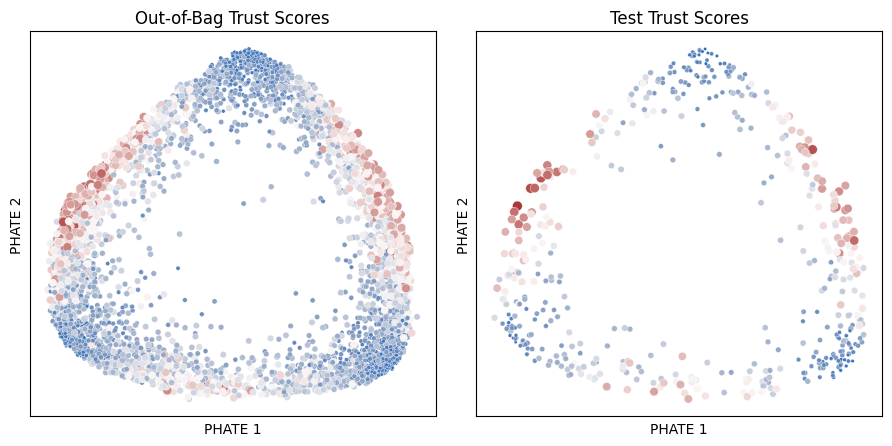

In [10]:
# RF-PHATE train/test plots
fig, axes = plt.subplots(1, 2, figsize = (11, 5))
plt.subplots_adjust(hspace = 0.5, wspace = 0.1)
color_palette = sns.color_palette('vlag', as_cmap = True)


min_size = 5
max_size = 50

oob_scale = reverse_scale(trust_scores_oob, min_size = min_size, max_size = max_size)
test_scale = reverse_scale(trust_scores_test, min_size = min_size, max_size = max_size)

sns.scatterplot(ax = axes[0], x = emb[inds_train, 0], y = emb[inds_train, 1],
                hue = oob_scale, 
                size = oob_scale,
                sizes = (min_size, max_size),
                palette = color_palette)


sns.scatterplot(ax = axes[1], x = emb[inds_test, 0], y = emb[inds_test, 1],
                hue = test_scale, 
                size = test_scale,
                sizes = (min_size, max_size),
                palette = color_palette)


axes[0].set_title('Out-of-Bag Trust Scores')
axes[1].set_title('Test Trust Scores')

for ax in axes:
    ax.set_xlabel('PHATE 1')
    ax.set_ylabel('PHATE 2')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.legend([], [], frameon = False)

In [11]:
# Get trust score quantiles for both OOB and Test points
oob_trust_quantiles = rf.trust_quantiles
test_trust_quantiles = rf.trust_quantiles_test

In [12]:
# The number of points dropped based on low trust quantiles
n_oob_dropped = []
n_test_dropped = []

for q in oob_trust_quantiles:
    n_oob_dropped.append(np.sum(trust_scores_oob < q))
n_oob_dropped = np.array(n_oob_dropped)

for q in oob_trust_quantiles:
    n_test_dropped.append(np.sum(trust_scores_test < q))
n_test_dropped = np.array(n_test_dropped)

Text(0.5, 0, 'Trust Score Threshold')

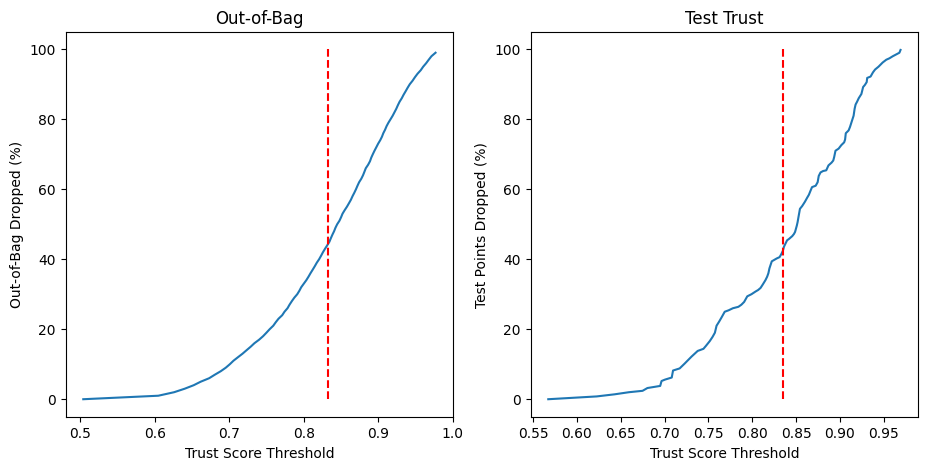

In [13]:
# Plot of test  and oob trust score quantiles
fig, axes = plt.subplots(1, 2, figsize = (11, 5))


sns.lineplot(ax = axes[0], x = oob_trust_quantiles, y = n_oob_dropped / len(y_train) * 100)
sns.lineplot(ax = axes[1], x = test_trust_quantiles, y = n_test_dropped / len(y_test) * 100)

axes[0].vlines(x = np.mean(trust_scores_oob), color = 'red', linestyle = '--',
               ymin = 0, ymax = 100)

axes[1].vlines(x = np.mean(trust_scores_test), color = 'red', linestyle = '--', 
               ymin = 0, ymax = 100)


axes[0].set_title('Out-of-Bag')
axes[0].set_ylabel('Out-of-Bag Dropped (%)')
axes[0].set_xlabel('Trust Score Threshold')

axes[1].set_title('Test Trust')
axes[1].set_ylabel('Test Points Dropped (%)')
axes[1].set_xlabel('Trust Score Threshold')

In [14]:
# Check accuracy after dropping unclassifiable points
oob_drop_accuracy = []
test_drop_accuracy = []

oob_prop_misclass_dropped = []
test_prop_misclass_dropped = []

for q in oob_trust_quantiles:

    idx_temp = trust_scores_oob > q
    idx_temp_test = trust_scores_test > q

    oob_preds = np.argmax(rf.oob_decision_function_, axis = 1)[idx_temp]
    dropped_oob_preds = np.argmax(rf.oob_decision_function_, axis = 1)[~idx_temp]

    oob_drop_accuracy.append(np.mean(y_train[idx_temp] == oob_preds))

    try:
        test_drop_accuracy.append(np.mean(y_test[idx_temp_test] == rf.predict(x_test[idx_temp_test])))

    except:
        test_drop_accuracy.append(1)

    # Add proportion of misclassified points dropped

    oob_prop_misclass_dropped.append(np.mean(y_train[~idx_temp] != dropped_oob_preds))

    try:
        test_prop_misclass_dropped.append(np.mean(y_test[~idx_temp_test] != rf.predict(x_test[~idx_temp_test])))
    except:
        continue # TODO: UPDATE THIS



oob_drop_accuracy = np.array(oob_drop_accuracy)
test_drop_accuracy = np.array(test_drop_accuracy)

oob_prop_misclass_dropped = np.array(oob_prop_misclass_dropped)
test_prop_misclass_dropped = np.array(test_prop_misclass_dropped)

In [27]:
oob_prop_misclass_dropped

array([0.        , 0.53333333, 0.46666667, 0.44444444, 0.42222222,
       0.39111111, 0.40740741, 0.41269841, 0.40555556, 0.4       ,
       0.39333333, 0.38585859, 0.37777778, 0.37094017, 0.36507937,
       0.36296296, 0.35972222, 0.35424837, 0.35308642, 0.3497076 ,
       0.34888889, 0.34920635, 0.34848485, 0.34589372, 0.34074074,
       0.33777778, 0.33247863, 0.33004115, 0.32936508, 0.32796935,
       0.32444444, 0.31971326, 0.31527778, 0.31515152, 0.31111111,
       0.30920635, 0.30802469, 0.3033033 , 0.30116959, 0.2980057 ,
       0.295     , 0.29214092, 0.28994709, 0.2878553 , 0.28585859,
       0.28197531, 0.27922705, 0.27706856, 0.27407407, 0.27120181,
       0.26666667, 0.26405229, 0.26153846, 0.25786164, 0.25679012,
       0.25454545, 0.25119048, 0.24912281, 0.24636015, 0.24369115,
       0.24037037, 0.23715847, 0.23405018, 0.23174603, 0.22916667,
       0.22598291, 0.22356902, 0.2212272 , 0.21895425, 0.21674718,
       0.21396825, 0.21158059, 0.20987654, 0.20730594, 0.20540

In [26]:
# Probably not the best metric; it does worse the better the model accuracy!
print(oob_prop_misclass_dropped / (1 - oob_drop_accuracy))

[ 0.          3.49926362  3.11346445  3.01710731  2.90909091  2.71869919
  2.90612704  3.01421092  3.01436266  3.02772643  3.02851711  3.01828835
  2.99799599  2.98812915  2.98701299  3.03129549  3.0625      3.06277233
  3.12443379  3.15515894  3.22879177  3.32822673  3.41670899  3.47397606
  3.47860697  3.52941176  3.52596766  3.59001717  3.70535714  3.81040752
  3.85660377  3.86268357  3.87449799  4.04332689  4.07048458  4.18716931
  4.34858388  4.34275184  4.46948488  4.54458689  4.63081395  4.7294765
  4.88233487  5.05718382  5.25812873  5.28703704  5.42817391  5.64793599
  5.77777778  5.92769679  5.82524272  6.00242571  6.2079459   6.19746998
  6.72855134  7.06102117  7.10510204  7.53207237  7.76034483  8.02875303
  8.01234568  8.00409836  8.00451613  8.38819876  8.63372093  8.47435897
  8.77078477  9.12562189  9.5543672  10.07874396  9.96059113 10.22639541
 11.49758454 11.44894147 12.64864865 14.3125     13.55921053 15.85414585
 16.24145299 15.30696203 14.39583333 13.50720165 16.

/tmp/ipykernel_2789934/1550204765.py:2: RuntimeWarning: divide by zero encountered in divide
  print(oob_prop_misclass_dropped / (1 - oob_drop_accuracy))


In [16]:
len(oob_prop_misclass_dropped)

100

In [17]:
test_prop_misclass_dropped

array([0.        , 0.28571429, 0.2       , 0.25      , 0.4375    ,
       0.36842105, 0.38461538, 0.42857143, 0.38709677, 0.43902439,
       0.43181818, 0.41176471, 0.42857143, 0.42622951, 0.39130435,
       0.40277778, 0.38157895, 0.38554217, 0.39325843, 0.37894737,
       0.38095238, 0.36036036, 0.35897436, 0.368     , 0.36220472,
       0.36153846, 0.35606061, 0.34814815, 0.3381295 , 0.32653061,
       0.32      , 0.32467532, 0.32051282, 0.31446541, 0.31707317,
       0.31176471, 0.30857143, 0.31666667, 0.31016043, 0.30964467,
       0.31343284, 0.31034483, 0.30434783, 0.30660377, 0.29816514,
       0.28634361, 0.28820961, 0.28755365, 0.28389831, 0.28033473,
       0.27016129, 0.26482213, 0.2605364 , 0.25735294, 0.25362319,
       0.25177305, 0.24652778, 0.24657534, 0.24080268, 0.23762376,
       0.23606557, 0.23225806, 0.22884013, 0.22530864, 0.22392638,
       0.22629969, 0.22155689, 0.22189349, 0.21994135, 0.21676301,
       0.21126761, 0.20949721, 0.20936639, 0.20708447, 0.20485

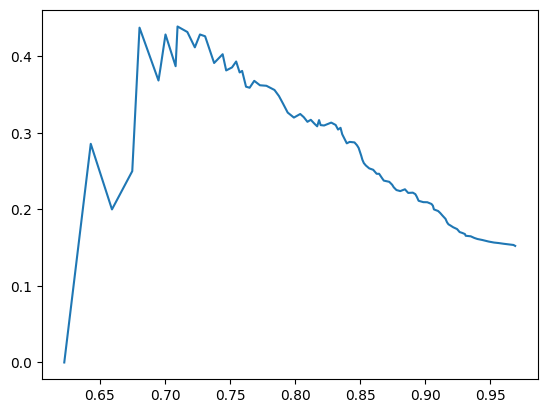

In [18]:
# Perhaps take proportion of correctly classified points over the overall classification accuracy, or something like that
plt.plot(test_trust_quantiles[1:], test_prop_misclass_dropped)

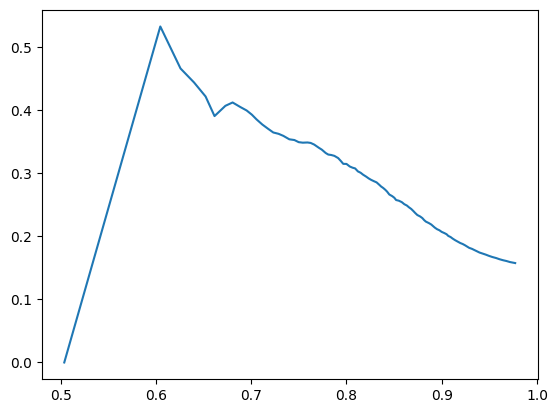

In [19]:
plt.plot(oob_trust_quantiles, oob_prop_misclass_dropped)

Text(0.5, 0, 'Trust Score Threshold')

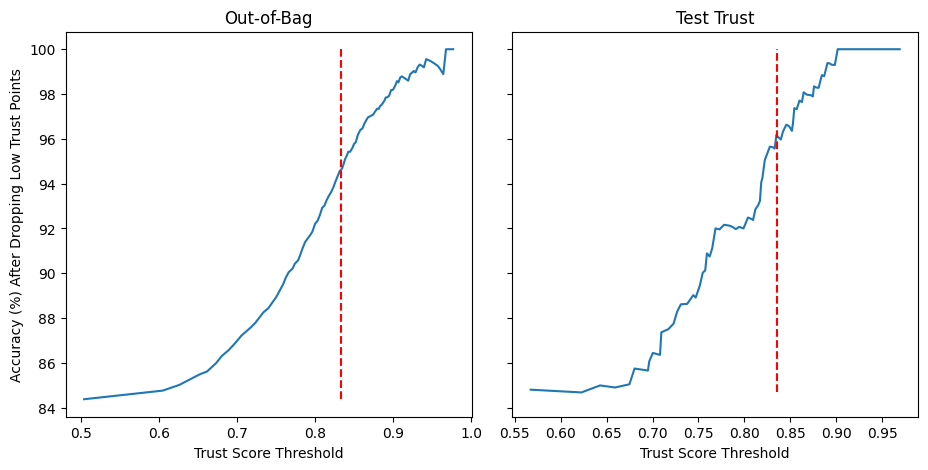

In [20]:
fig, axes = plt.subplots(1, 2, figsize = (11, 5), sharey = True)
plt.subplots_adjust(hspace = 0.5, wspace = 0.1)

sns.lineplot(ax = axes[0], x = oob_trust_quantiles, y = oob_drop_accuracy * 100)
sns.lineplot(ax = axes[1], x = test_trust_quantiles, y = test_drop_accuracy * 100)

axes[0].vlines(x = np.mean(trust_scores_oob), color = 'red', linestyle = '--',
               ymin = np.min(oob_drop_accuracy) * 100, ymax = np.max(oob_drop_accuracy) * 100)

axes[1].vlines(x = np.mean(trust_scores_test), color = 'red', linestyle = '--', 
               ymin = np.min(test_drop_accuracy) * 100, ymax = np.max(test_drop_accuracy) * 100)


axes[0].set_title('Out-of-Bag')
axes[0].set_ylabel('Accuracy (%) After Dropping Low Trust Points')
axes[0].set_xlabel('Trust Score Threshold')

axes[1].set_title('Test Trust')
axes[1].set_xlabel('Trust Score Threshold')

In [21]:
rffull = RFGAP(oob_score = True, random_state = 42)
rffull.fit(x, y)
full_trust_scores = rffull.get_trust_scores()

Currently minus not taking oob_correct into account


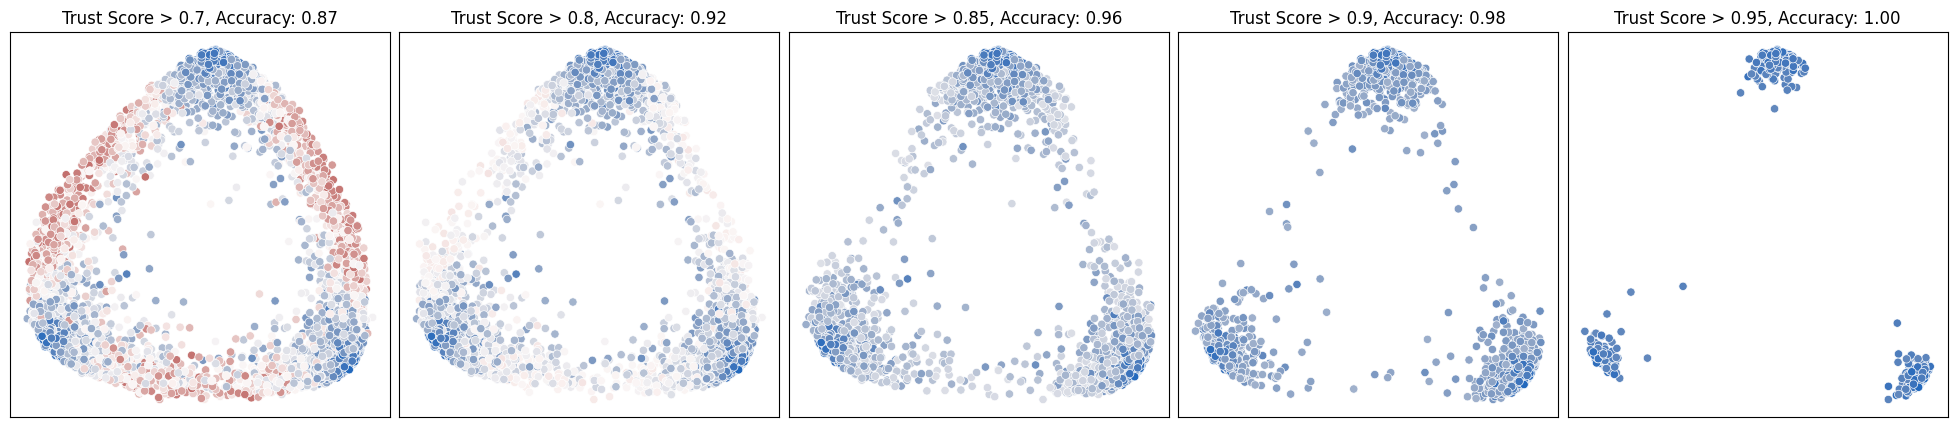

In [22]:
qs = [0.7, 0.8, 0.85, 0.9, 0.95]

fig, axes = plt.subplots(1, 5, figsize = (25, 5))
plt.subplots_adjust(hspace = 0.5, wspace = 0.025)
color_palette = sns.color_palette('vlag', as_cmap = True)

# Define size and colormap outside the loop
size = reverse_scale(full_trust_scores)
colormap = reverse_scale(full_trust_scores)

for i, ax in enumerate(axes.ravel()):

    q = qs[i]
    idx_temp = full_trust_scores > q
    hue_norm = (int(np.min(colormap)), int(np.quantile(colormap, 0.97)))
    oob_preds = np.argmax(rffull.oob_decision_function_, axis = 1)[idx_temp]

    sns.scatterplot(ax = ax, x = emb[idx_temp, 0], y = emb[idx_temp, 1],
                    hue = colormap[idx_temp],
                    hue_norm = hue_norm,
                    sizes = size[idx_temp],
                    palette = color_palette,
                    legend = False)  # Disable legend for each subplot
    
    ax.set_title(f'Trust Score > {q}, Accuracy: {np.mean(y[idx_temp] == oob_preds):.2f}')
    ax.set_xticks([])
    ax.set_yticks([])   

In [23]:
# Still to look at acuracy of dropped points



In [24]:
# make a table that shows thresholds, accuracies, and proportion of misclassified points using muliple datasets